In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [46]:
diesel_df = pd.read_csv('diesel_data.csv')
petrol_df = pd.read_csv('petrol_data.csv')

In [47]:
diesel = {'fuel': 'diesel', 'Vd': 1.9, 'rv': 22, 'CV': 42500, 'rho': 840, 'clfm': 55.9 * 10 ** (-6)}
petrol = {'fuel': 'petrol', 'Vd': 1.198, 'rv': 10.3, 'CV': 44000, 'rho': 770, 'clfm': 50.199 * 10 ** (-6)}

arho = 1.2

gamma = 1.4

In [48]:
def remove_columns(df):
    return df[[ 'Air Flow Pressure (Pa)', 'Torque (Nm)', 'Engine Speed (rpm)', 'Fuel Flow Rate (cm^3/min)', 'Exhaust Temp. (C)', 'Plant In Temp. (C)']]

In [49]:
diesel_df = remove_columns(diesel_df)
petrol_df = remove_columns(petrol_df)

In [50]:
def addCalculatedColumns(df, dict):
    df['Brake Power [kW]'] = df['Torque (Nm)'] * df['Engine Speed (rpm)'] * 2 * np.pi / 60 * 10 ** (-3)
    df['BMEP [kPa]'] = df['Torque (Nm)'] * 4 * np.pi / dict['Vd']
    df['Air Mass Flow Rate [kg/s]'] = dict['clfm']  * arho * df['Air Flow Pressure (Pa)']
    df['Fuel Mass Flow Rate [kg/s]'] = df['Fuel Flow Rate (cm^3/min)'] * 60 / 10 ** 6 * dict['rho']
    df['Cut-off Ratio'] = ((df['Exhaust Temp. (C)'] + 273) / (df['Plant In Temp. (C)'] + 273)) ** (1 / gamma)
    df['Air to Fuel Ratio'] = df['Air Mass Flow Rate [kg/s]'] / df['Fuel Mass Flow Rate [kg/s]']
    df['Brake Thermal Efficiency'] = (df['Brake Power [kW]'] * 10 ** 3)/ (df['Fuel Mass Flow Rate [kg/s]'] * dict['CV'])
    df['Volumetric Efficiency'] = (df['Fuel Mass Flow Rate [kg/s]'] * 10 ** 3) / (dict['Vd'] * arho)
    df['Brake Specific Fuel Capacity'] = df['Fuel Mass Flow Rate [kg/s]'] / df['Brake Power [kW]'] * 60 * 10 ** (-3)

    if dict['fuel'] == 'petrol':
        df['Thermal Efficiency'] = 1 - 1 / (dict['rv'] ** (gamma - 1))

    if dict['fuel'] == 'diesel':
        df['Thermal Efficiency'] = 1 - 1 / gamma * 1 / (dict['rv'] ** (gamma - 1)) * (df['Cut-off Ratio'] ** gamma - 1) / (df['Cut-off Ratio'] - 1)
    
    return df

In [51]:
diesel_df[diesel_df['Torque (Nm)'] == 100.21]

,Air Flow Pressure (Pa),Torque (Nm),Engine Speed (rpm),Fuel Flow Rate (cm^3/min),Exhaust Temp. (C),Plant In Temp. (C)
57,519.26,100.21,1802.53,63.8,455.58,17.25


In [52]:
diesel_df = addCalculatedColumns(diesel_df, diesel)
petrol_df = addCalculatedColumns(petrol_df, petrol)

In [53]:
def scatter(axs, df, x, y, row, col):
    r = np.corrcoef(df[x], df[y])[0,1]
    axs[row, col].scatter(df[x], df[y])
    axs[row,col].set(xlabel=x, ylabel=y)
    axs[row, col].text(0.5, 0.9, f'Corr. coeff., r = {np.round(r, 2)}', horizontalalignment='center', verticalalignment='center', transform=axs[row, col].transAxes)

In [54]:
labels = ['Brake Power [kW]', 'Air Mass Flow Rate [kg/s]',
       'Fuel Mass Flow Rate [kg/s]', 'Air to Fuel Ratio',
       'Brake Thermal Efficiency', 'Volumetric Efficiency',
       'Brake Specific Fuel Capacity', 'Cut-off Ratio', 'Thermal Efficiency']

In [55]:
def plot(df):
    row = 0
    col = 0
    f, axs = plt.subplots(3,3,figsize=(12,8))
    f.tight_layout(pad=3)
    for label_index in range(len(labels)):
        scatter(axs, df, 'Engine Speed (rpm)', labels[label_index], row, col)
        if (label_index+1) % 3 == 0:
                col = 0
                row += 1
        else:
                col += 1
    plt.show()

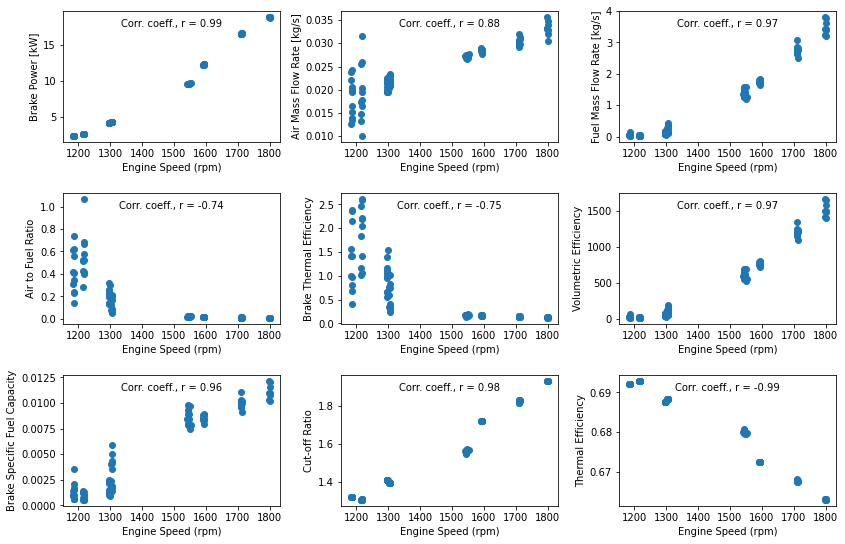

In [56]:
plot(diesel_df)


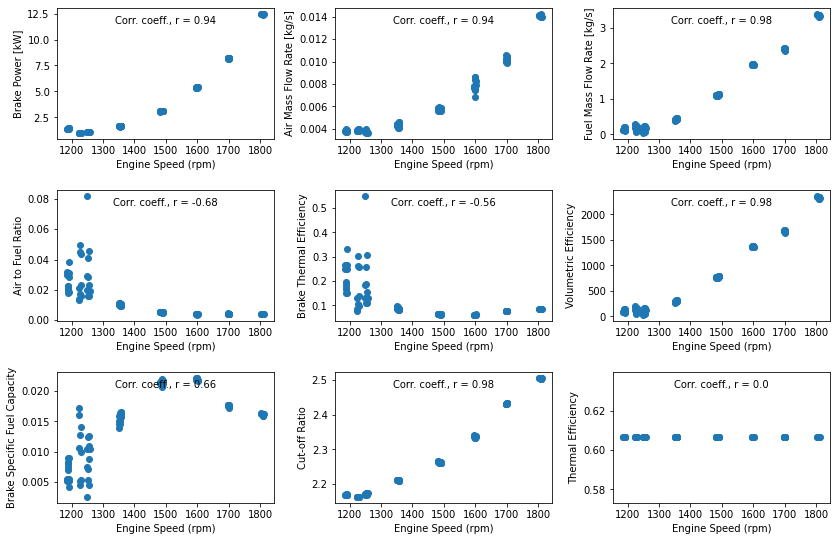

In [57]:
plot(petrol_df)